In [17]:
# Importing libraries
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import matplotlib_inline as line
import json
from scipy.optimize import minimize

# Importing packages
import feedstock2 as fs
import pp2 as pp
import gasifier2 as g
import fuel as fu
import energy as en
import outputs as op

In [18]:
# Grabbing data from JSON file
with open('data.json','r') as dataFile:
    data = json.load(dataFile)
    dataFile.close()

In [19]:
Table2 = data['Thamavithya2010']['Table2']
df = pd.DataFrame(Table2)
df.head()

,Qf,Qs,ER,Tbed,Toxi,Tenl,Tgas,CO,H2,CH4,CO2,N2,HHVgas(MJ/Nm3),CarbonConv,GasYield(Nm3/kg),Eff
0,50,5,0.35,732,635,701,531,12.04,6.06,1.56,14.26,66.08,3.02,50.51,1.41,23.44
1,50,5,0.30,728,630,692,532,13.76,6.84,2.28,13.92,63.20,3.64,48.73,1.26,25.38
2,50,5,0.25,710,603,638,502,15.84,7.09,2.59,13.04,61.44,4.08,43.93,1.08,24.37
3,50,5,0.20,701,576,601,487,17.32,8.57,3.45,12.93,57.73,4.82,40.15,0.92,24.59
4,50,5,0.15,694,556,590,452,18.04,10.21,3.46,12.36,55.93,5.14,31.33,0.72,20.35


In [20]:
fuelID = "ThamaSawdust"
species=['CO','H2','CH4','CO2','N2']
moist = fu.moisture(fuelID)
ER = 0.35
experimental = np.array([0.1204, 0.0606, 0.0156, 0.1426, 0.6608])

In [21]:
Tquasi, err = g.findTquasi(fuelID, experimental, moist=moist, T0=531+273.15, air=ER, species=species)
print(Tquasi)

682.9238847455201


In [22]:
report = g.gasifier(fuelID, T=531+273.15, moist=moist, air=ER, species=species)
for sp in species:
    print(sp, report[sp]*100)

CO 4.316859799451124
H2 13.29781436679788
CH4 2.3528162249201445
CO2 17.645921819318612
N2 41.45704345564427


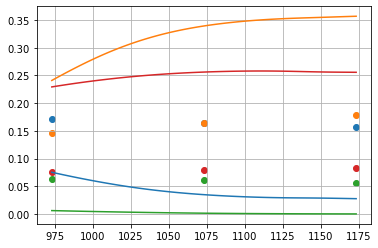

In [23]:
fuelID = 'GuoCorn'
T = np.array([700, 800, 900]) # °C
T = T + 273.15 # K
ER = 0.21 # constant
moist = 0
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.array([[17.1, 14.7, 6.36, 7.58],
                         [16.5, 16.4, 6.07, 7.97],
                         [15.7, 17.8, 5.60, 8.35]]) # %
experimental = experimental/100 # fraction
Tl = np.linspace(T[0], T[-1], 100) # K
CO2l = np.zeros_like(Tl)
COl = np.zeros_like(Tl)
CH4l = np.zeros_like(Tl)
H2l = np.zeros_like(Tl)
for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t, air=ER, species=species)
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.savefig("results.png")
plt.show()


1500.7229991896468 0.31982180274729805 0.16073262111431946
1639.4534316480276 0.35041644571266695 0.1579206266686656
1768.5854214534345 0.37715266701277106 0.15221577165569206


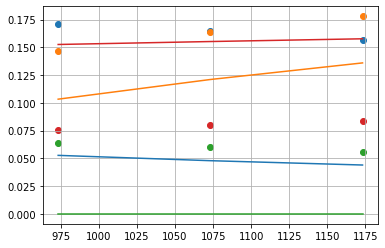

In [24]:
predicted = np.zeros_like(experimental)
for i, t in enumerate(T):
    X = g.findParams(fuelID, experimental[i], T0=t, air=ER, species=species)
    Tq, C_avail, sqerr = X
    report = g.gasifier(fuelID, T=Tq, air=ER, species=species, C_avail=C_avail)
    for j, sp in enumerate(species):
        predicted[i,j] = report[sp]
    print(Tq, C_avail, np.sqrt(sqerr))

plt.plot(T, predicted[:,0], label='CO2')
plt.plot(T, predicted[:,1], label='CO')
plt.plot(T, predicted[:,2], label='CH4') 
plt.plot(T, predicted[:,3], label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.savefig("results2.png")
plt.show()